# 1-Directional Shock Wave

In [19]:
import numpy as np
import scipy
import scipy.optimize
import pandas as pd
import matplotlib.pyplot as plt


#Defining Shock speed with pressure, density and gamma

def speed_of_sound(gamma, pressure, density):  
    return np.sqrt(gamma * pressure / density) 

******************Regions & their notations******************

left side filled with high-Pressure air and right side with low pressure gas
Assuming both gas to be Air(gamma=1.4)

1- Region between Right wall and Shock wave

2- Region between Shock wave and Contact discontinuity

3- Region between Contact Discontinuity and expansion wave

4- Region between Expansion wave and left Wall


In [20]:
#Shock tube functions 

def shock(p2, p4, p1, rho4, rho1, gamma):
    p = (p2 / p1 - 1.)
    a4 = speed_of_sound(gamma, p4, rho4)
    a1 = speed_of_sound(gamma, p1, rho1)
    f1 = (gamma-1) / (2.*gamma) * (a1 / a4) * p / np.sqrt(1. + (gamma+1) / (2.*gamma) * p)
    f1 = (1. - f1) ** ((2.*gamma) / (gamma-1))

    return p4 * f1 - p2


def left_right(pl, ul, rhol, pr, ur, rhor, gamma=1.4):
    rho4 = rhol
    p4 = pl
    u4 = ul
    rho1 = rhor
    p1 = pr
    u1 = ur
    
# Pressure behind shock wave

    p2 = scipy.optimize.fsolve(shock, p4, (p4, p1, rho4, rho1, gamma))[0]
    p = (p2 / p1 - 1.)
    a1 = speed_of_sound(gamma, p1, rho1)
    gamma_f1 = (gamma-1) /(2.* gamma)
    gamma_f2 = (gamma+1) /(2.*gamma)
    f2 = np.sqrt(1. + gamma_f2 * p)
    u2 = a1 * p / (gamma * f2)
    rho2 = rho1 * (1. + gamma_f2 * p) / (1. + gamma_f1 * p)

#Speed Of Shock

    w = a1 * f2

#Expansion Wave

    p3 = p2
    u3 = u2
    rho3 = rho4 * (p3 / p4) ** (1. / gamma)
    
    return (p4, rho4, u4), (p3, rho3, u3), (p2, rho2, u2), (p1, rho1, u1), w


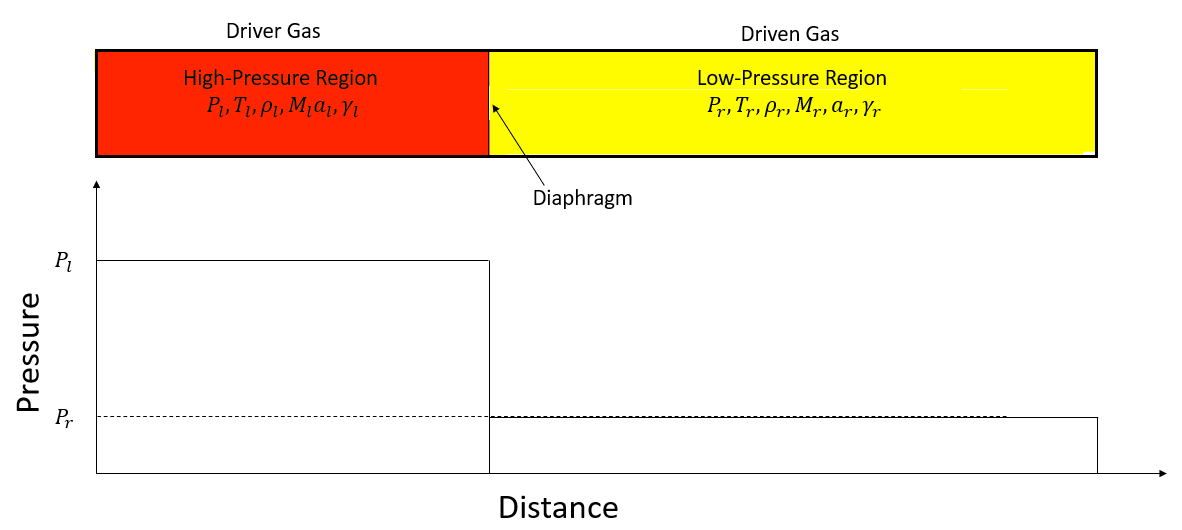

In [21]:
#Assigning Position for vsrious regions

def position(pl, pr, region1, region3, w, xi, t, gamma):
    p4, rho4 = region1[:2]
    p3, rho3, u3 = region3
    a4 = speed_of_sound(gamma, p4, rho4)
    a3 = speed_of_sound(gamma, p3, rho3)
    x_shock = xi + w * t
    x_con_dis = xi + u3 * t
    x_expn_end = xi + (u3 - a3) * t
    x_expn_st = xi - a4 * t
  
    return x_expn_st, x_expn_end, x_con_dis, x_shock


def states(pl, pr, region4, region3, region2, region1):  
   
    return {'Region 4': region4,
            'Region 3': region3,
            'Region 2': region2,
            'Region 1': region1}

Assigning the Position for Waves

x_shock = Position on Shock Wave

x_con_dis = Position of contact Discontinuity

x_expn_end = one end of Expasnsion Wave

x_expn_st = one end of expansion wave

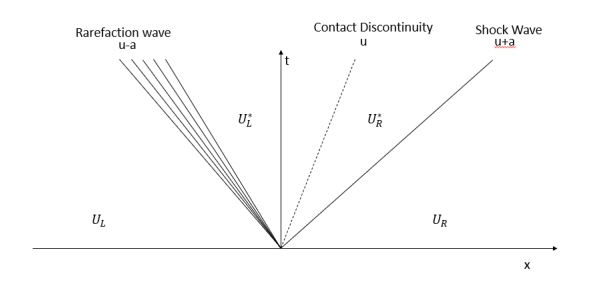

In [22]:
def variables(pl, pr, xl, xr, positions, state4, state3, state2, state1,
                  npts, gamma, t, xi):
   
    x_expn_st, x_expn_end, x_con_dis, x_shock = positions
    p4, rho4, u4 = state4
    p3, rho3, u3 = state3
    p2, rho2, u2 = state2
    p1, rho1, u1 = state1
    
    
    x_arr = np.linspace(xl, xr, npts)
    rho = np.zeros(npts, dtype=float)
    p = np.zeros(npts, dtype=float)
    u = np.zeros(npts, dtype=float)
    a4 = speed_of_sound(gamma, p4, rho4)
    for i, x in enumerate(x_arr):
        if x < x_expn_st:
            rho[i] = rho4
            p[i] = p4
            u[i] = u4
        elif x < x_expn_end:
            u[i] = 2. / (gamma+1) * (a4 + (x - xi) / t)
            f = 1. - 0.5 * (gamma-1) * u[i] / a4
            rho[i] = rho4 * f ** (2. / (gamma-1))
            p[i] = p4 * f ** (2. * gamma / (gamma-1))
        elif x < x_con_dis:
            rho[i] = rho3
            p[i] = p3
            u[i] = u3
        elif x < x_shock:
            rho[i] = rho2
            p[i] = p2
            u[i] = u2
        else:
            rho[i] = rho1
            p[i] = p1
            u[i] = u1
            
    return x_arr, p, rho, u

In [23]:
#Solving The Equations

def solve(left_state, right_state, geometry, t, gamma=1.4, npts=500):
 
    pl, rhol, ul = left_state
    pr, rhor, ur = right_state
    xl, xr, xi = geometry

# calculate regions
    
    region1, region3, region4, region5, w = left_right(pl, ul, rhol, pr, ur, rhor, gamma)
    regions = states(pl, pr, region1, region3, region4, region5)

# calculate positions

    x_positions = position(pl, pr, region1, region3, w, xi, t, gamma)
    pos_description = ('Rarefaction Ends', 'Rarefaction Starts','Contact Discontinuity', 'Shock Wave')
    positions = dict(zip(pos_description, x_positions))

# Creating Array to save values
    
    x, p, rho, u = variables(pl, pr, xl, xr, x_positions, region1, region3, region4, region5,
                                 npts, gamma, t, xi)
    val_dict = {'x': x, 'p': p, 'rho': rho, 'u': u}

    return positions, regions, val_dict

# Initial Conditions and Plotting

In [31]:
gamma = 1.4
npts = 500
t = 0.05               #Insert between 0-0.1
x = int(input('High-Pressure in bar ')) 
y = float(input('Low-Pressure in bar ')) 
left_state = (x,1,0)
right_state = (y, 0.125, 0.)

positions, regions, values = solve(left_state=left_state, right_state=right_state, geometry=(0., 1., 0.4), t=t, 
        gamma=gamma, npts=npts)

print('Positions of :')
for desc, vals in positions.items():
        print('{0:10} : {1}'.format(desc, vals))
        
print('...')
print('...')
print('...')

data = []
for i,j in (regions.items()):
    data.append([i,j])
df = pd.DataFrame(data,columns = ['Regions','(Pressure,Density,Velocity)'])

pd.set_option('max_colwidth', 80) 
print(df)

High-Pressure in bar 10
Low-Pressure in bar 1
Positions of :
Rarefaction Ends : 0.21291713066130294
Rarefaction Starts : 0.38888889273602856
Contact Discontinuity : 0.5466431350622714
Shock Wave : 0.6770401464267504
...
...
...
    Regions                                    (Pressure,Density,Velocity)
0  Region 4                                                     (10, 1, 0)
1  Region 3  (3.0313017805064697, 0.42631942817849533, 2.9328627012454276)
2  Region 2  (3.0313017805064697, 0.26557371170530714, 2.9328627012454276)
3  Region 1                                              (1.0, 0.125, 0.0)


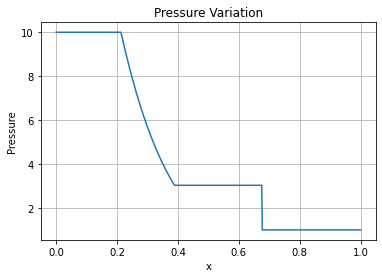

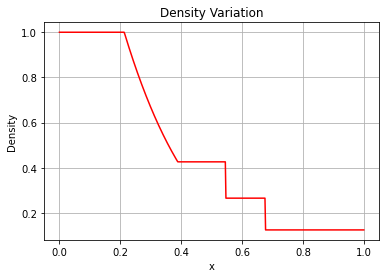

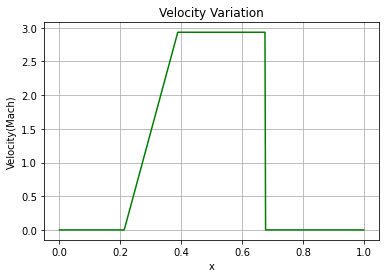

In [32]:
#Plotting the graph for Pressure, Density and Velocity

plt.plot(values['x'],values['p'])
plt.xlabel('x')
plt.ylabel('Pressure')
plt.title('Pressure Variation')
plt.grid()
plt.show()
    
plt.plot(values['x'],values['rho'],color = 'r')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Density Variation')
plt.grid()
plt.show()
    
plt.plot(values['x'],values['u'],color = 'g')
plt.xlabel('x')
plt.ylabel('Velocity(Mach)')
plt.title('Velocity Variation')
plt.grid()
plt.show()
